# Support Vector Regression for Price Prediction

Use Technical Analysis indicators as input features.

Split train/test
Fit SVR to technical indicators.
Report mean squared error.

Prediction for single stock. In this notebook, AOT is chosen arbitrary.
- Predict tomorrow's closing price.
- Use five technical indicators.
- Technical indicator choice and methodology came from Henrique2018.
- Model trained using data from 2014-2016. Model test on holdout data set of 2017, 2018-2020.
- Linear Kernel perform better than RBF. Confirms literature knowledge. RBF was getting 88 MSE on training.
- Linear Kernel performance degrades in holdout sets. MSE and MAE are increasing exponentially.
- For this stock, can test with RBF kernel and windowed retraining.


## Linear Kernel


| | In-sample (Training) | Out-of-sample (Holdout) | Out-of-sample (Holdout) |
| --- | --- | --- | --- |
| Year | 2014-2016 | 2017 | 2018-2020 |
| MSE | 0.306 | 1.002 | 4.980 |
| MAE | 0.405 | 0.755 | 1.398 |
| R2 | 0.9943 | 0.986 | 0.8445 |



## RBF Kernel

| | In-sample (Training) |
| --- | --- |
| Year | 2014-2016 |
| MSE | 1.149 |
| MAE | 0.661 |
| R2 | 0.978 |


TODO:
- Try Three-day, Five-day, Ten-day, Twenty-day ahead.
- Instead of price, predict returns instead b/c return is invariant and we would like to predict market invariant.


References
- HENRIQUE, Bruno Miranda; SOBREIRO, Vinicius Amorim; KIMURA, Herbert. Stock price prediction using support vector regression on daily and up to the minute prices. The Journal of finance and data science, 2018, 4.3: 183-201.
- Support Vector Regression in Python Using Scikit-Learn https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
- In-Depth: Support Vector Machines https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html#Fitting-a-support-vector-machine
- Support vector regression for multivariate time series prediction
https://stats.stackexchange.com/questions/14482/support-vector-regression-for-multivariate-time-series-prediction
- SVM From Scratch — Python https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2
- Support Vector Regression in 6 Steps with Python https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
- Awad M., Khanna R. (2015) Support Vector Regression. In: Efficient Learning Machines. Apress, Berkeley, CA https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

In [2]:
DATA_HOME = os.path.join("..","historical")

symbols = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 'BJC', 'BTS']
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["AOT"]
df.index = pd.to_datetime(df.index)
daily = df['2014-01-01':'2016-12-31']

In [3]:
from talib.abstract import *

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
daily.loc[:,"WMA"] = WMA(inputs).tolist()
daily.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
daily.loc[:,"ATR"] = ATR(inputs).tolist()
daily.loc[:,"RSI"] = RSI(inputs).tolist()

daily

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2014-01-02,16.049999,14.650000,16.049999,14.650000,69637000.0,8.198195,NaN,NaN,NaN,NaN,NaN
2014-01-03,14.950000,14.250000,14.300000,14.500000,121443000.0,8.114254,NaN,NaN,NaN,NaN,NaN
2014-01-06,14.400000,13.750000,14.400000,14.250000,103236000.0,7.974353,NaN,NaN,NaN,NaN,NaN
2014-01-07,15.150000,14.350000,14.400000,15.150000,112178000.0,8.477996,NaN,NaN,NaN,NaN,NaN
2014-01-08,15.100000,14.500000,15.050000,14.500000,105933000.0,8.114254,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,39.700001,39.000000,39.099998,39.400002,21080000.0,37.686546,38.848,39.056989,-7.910668e+06,0.563878,56.436543
2016-12-27,39.500000,39.200001,39.500000,39.299999,20892000.0,37.590893,38.996,39.113764,-8.650068e+06,0.545030,55.044081
2016-12-28,39.500000,39.299999,39.400002,39.400002,17582000.0,37.686546,39.120,39.171828,-8.166073e+06,0.520385,56.207686


# Prepare feature

We want X,y before splitting.

In [4]:
data = daily

# Target: Tomorrow's closing price
data["Tomorrow"] = data["Close"].shift(-1)
data = data.dropna()

# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

# data[[SMA, WMA, RSI, ADOSC, ATR]]
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Tomorrow
Date,,,,,,,,,,,,
2014-02-12,17.750000,17.299999,17.350000,17.650000,59391000.0,9.877007,16.716,16.943011,-8.798898e+05,0.568682,63.179681,17.600000
2014-02-13,17.799999,17.450001,17.650000,17.600000,50576000.0,9.849026,16.836,17.022688,1.468807e+06,0.553062,62.461179,18.299999
2014-02-17,18.500000,17.900000,17.900000,18.299999,121609000.0,10.240747,16.986,17.141183,1.519395e+07,0.577843,67.955592,18.650000
2014-02-18,18.750000,18.100000,18.299999,18.650000,113987000.0,10.436608,17.120,17.274086,4.453649e+07,0.582997,70.296598,18.799999
2014-02-19,18.950001,18.600000,18.600000,18.799999,95161000.0,10.520550,17.234,17.407204,5.681675e+07,0.566355,71.265458,18.299999
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,39.000000,38.700001,38.900002,38.799999,15346000.0,37.112637,38.712,38.989462,-9.761901e+06,0.538022,49.289455,39.400002
2016-12-26,39.700001,39.000000,39.099998,39.400002,21080000.0,37.686546,38.848,39.056989,-7.910668e+06,0.563878,56.436543,39.299999
2016-12-27,39.500000,39.200001,39.500000,39.299999,20892000.0,37.590893,38.996,39.113764,-8.650068e+06,0.545030,55.044081,39.400002


In [5]:
# Prepare data for training. Split train/test 60/40.
# TODO: get rid of random_state to check when everything is stable?

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## SVR - RBF Kernel

In [6]:
# Use StandardScaler 
# Note about pipeline
# see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(kernel='rbf') # RBF kernel. Note the result here is poorer than linear kernel.
model = make_pipeline(StandardScaler(), svr)

In [7]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
y_pred = model.predict(X_test)
# y_pred # Check output

In [9]:
mse = mean_squared_error(y_test, y_pred)
mse

1.148969203450109

In [10]:
rmse = np.sqrt(mse)
rmse

1.0718998103601423

In [11]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.6613284468332977

In [12]:
r2 = r2_score(y_test, y_pred)
r2

0.978770292181693

In [13]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 1.148969203450109, 'mae': 0.6613284468332977, 'r2': 0.978770292181693}

# SVR - Linear Kernel

In [14]:
svr = SVR(kernel='linear')
model = make_pipeline(StandardScaler(), svr)
model.fit(X_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [15]:
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mse

0.30589160819296773

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.4047101353199144

In [18]:
r2 = r2_score(y_test, y_pred)
r2

0.9943479864851829

In [19]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.30589160819296773,
 'mae': 0.4047101353199144,
 'r2': 0.9943479864851829}

# Test on holdout set 1

In [20]:
holdout = df["2017-01-01":"2017-12-31"]
holdout

inputs = {
    'open': holdout["Open"],
    'high': holdout["High"],
    'low': holdout["Low"],
    'close': holdout["Close"],
    'volume': holdout["Volume"]
}

holdout.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout.loc[:,"WMA"] = WMA(inputs).tolist()
holdout.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout.loc[:,"ATR"] = ATR(inputs).tolist()
holdout.loc[:,"RSI"] = RSI(inputs).tolist()

holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2017-01-04,40.200001,39.700001,39.900002,39.799999,32333000.0,38.069149,NaN,NaN,NaN,NaN,NaN
2017-01-05,40.000000,39.599998,39.900002,39.599998,36294000.0,37.877842,NaN,NaN,NaN,NaN,NaN
2017-01-06,39.700001,39.400002,39.599998,39.400002,37487000.0,37.686546,NaN,NaN,NaN,NaN,NaN
2017-01-09,39.599998,39.400002,39.400002,39.400002,15158000.0,37.686546,NaN,NaN,NaN,NaN,NaN
2017-01-10,39.500000,39.200001,39.200001,39.299999,17693000.0,37.590893,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,66.750000,64.750000,65.000000,66.500000,30096100.0,64.495453,61.85,62.599462,3.044928e+07,1.006281,76.976450
2017-12-26,69.000000,66.250000,66.500000,68.500000,35599600.0,66.435173,62.26,63.077419,3.679868e+07,1.130832,81.611041
2017-12-27,70.000000,67.250000,68.750000,67.500000,55436900.0,65.465309,62.64,63.467742,2.161890e+07,1.246487,73.630182


In [21]:
# Target: Tomorrow's closing price
data = daily


holdout["Actual"] = holdout["Close"].shift(-1) # tomorrow's price if known today.
holdout.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-01-04,40.200001,39.700001,39.900002,39.799999,32333000.0,38.069149,NaN,NaN,NaN,NaN,NaN,39.599998
2017-01-05,40.000000,39.599998,39.900002,39.599998,36294000.0,37.877842,NaN,NaN,NaN,NaN,NaN,39.400002
2017-01-06,39.700001,39.400002,39.599998,39.400002,37487000.0,37.686546,NaN,NaN,NaN,NaN,NaN,39.400002
2017-01-09,39.599998,39.400002,39.400002,39.400002,15158000.0,37.686546,NaN,NaN,NaN,NaN,NaN,39.299999
2017-01-10,39.500000,39.200001,39.200001,39.299999,17693000.0,37.590893,NaN,NaN,NaN,NaN,NaN,39.099998


In [22]:
# Tomorrow predict
holdout = holdout.dropna()

holdout[0:1]

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-02-16,40.25,39.25,39.5,39.75,132149400.0,38.021324,40.224,40.367097,4.719233e+07,0.931658,44.793563,40.0


In [23]:
# Test predicting on one sample.

features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
features

y_pred = model.predict(features)
y_pred

array([39.96769452])

In [24]:
# Prediction for the holdout set.

holdout.loc[:,"Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2017-02-16,40.25,39.25,39.50,39.75,132149400.0,38.021324,40.224,40.367097,4.719233e+07,0.931658,44.793563,40.00,39.967695
2017-02-17,40.25,39.50,40.00,40.00,95819400.0,38.260452,40.260,40.360430,6.293177e+07,0.918682,47.121917,40.25,40.184469
2017-02-20,40.25,39.75,40.00,40.25,26441200.0,38.499577,40.302,40.369462,7.206268e+07,0.888776,49.419277,39.25,40.404344
2017-02-21,40.25,39.25,40.00,39.25,37411700.0,37.543068,40.296,40.312581,5.734317e+07,0.896721,41.628380,39.75,39.701591
2017-02-22,40.00,39.25,39.50,39.75,24814400.0,38.021324,40.310,40.288280,4.874037e+07,0.886241,46.195713,38.75,40.075578
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,64.75,64.25,64.50,64.75,7953000.0,62.798203,61.480,62.232258,2.578204e+07,0.929841,71.047742,66.50,63.926290
2017-12-25,66.75,64.75,65.00,66.50,30096100.0,64.495453,61.850,62.599462,3.044928e+07,1.006281,76.976450,68.50,64.812453
2017-12-26,69.00,66.25,66.50,68.50,35599600.0,66.435173,62.260,63.077419,3.679868e+07,1.130832,81.611041,67.50,65.675921


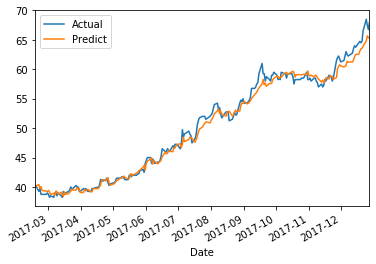

In [25]:
holdout[["Actual", "Predict"]].plot()

In [26]:
mse = mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mse

1.0023958543287486

In [27]:
mae = mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mae

0.75468454678399

In [28]:
r2 = r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)
r2

0.9864581336732797

In [29]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 1.0023958543287486, 'mae': 0.75468454678399, 'r2': 0.9864581336732797}

# Test on holdout set 2: 2018-2020

In [30]:
holdout2 = df["2018-01-01":"2020-04-30"]
holdout2


inputs = {
    'open': holdout2["Open"],
    'high': holdout2["High"],
    'low': holdout2["Low"],
    'close': holdout2["Close"],
    'volume': holdout2["Volume"]
}

holdout2.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout2.loc[:,"WMA"] = WMA(inputs).tolist()
holdout2.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout2.loc[:,"ATR"] = ATR(inputs).tolist()
holdout2.loc[:,"RSI"] = RSI(inputs).tolist()

# Tomorrow actual
holdout2.loc[:,"Actual"] = holdout2["Close"].shift(-1)
holdout2.head()

# Start prediction
holdout2 = holdout2.dropna()

holdout2.loc[:,"Predict"] = model.predict(holdout2[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2018-02-13,69.00,67.25,67.75,68.75,52994400.0,66.677628,69.82,69.647849,1.113314e+07,1.339552,44.383371,69.25,69.584050
2018-02-14,70.00,69.25,69.25,69.25,43254600.0,67.162560,69.74,69.586559,-8.786687e+05,1.333155,47.798638,69.25,69.796390
2018-02-15,69.75,69.25,69.75,69.25,24987500.0,67.162560,69.72,69.527957,-1.366328e+07,1.273644,47.798638,68.75,69.739983
2018-02-16,69.50,68.75,69.50,68.75,20776300.0,66.677628,69.69,69.439785,-2.426187e+07,1.236241,44.620835,69.25,69.396878
2018-02-19,69.50,68.75,69.00,69.25,26699700.0,67.162560,69.61,69.390860,-2.356025e+07,1.201509,48.320914,68.50,69.643743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,61.00,59.50,60.50,60.25,35754500.0,60.250000,53.97,55.387097,4.360691e+07,2.933290,57.538221,58.75,55.856364
2020-04-24,60.00,58.75,59.75,58.75,33376500.0,58.750000,54.44,55.721505,2.949192e+07,2.830913,54.005729,58.75,55.932839
2020-04-27,59.75,58.75,59.50,58.75,13851500.0,58.750000,54.64,56.043011,1.662923e+07,2.700133,54.005729,59.50,56.178997


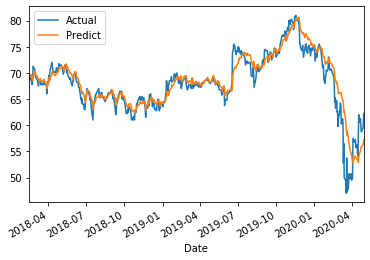

In [36]:
holdout2[["Actual", "Predict"]].plot()

In [32]:
mse = mean_squared_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mse

4.9803667437684105

In [33]:
mae = mean_absolute_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mae

1.398345322785512

In [34]:
r2 = r2_score(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
r2

0.8446125828907503

In [35]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 4.9803667437684105, 'mae': 1.398345322785512, 'r2': 0.8446125828907503}